In [7]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [8]:
import cfd
import cfdcc
import cfdplot
import cfdsim
import qsvtphi
import numpy as np
import time

In [9]:
def time_sim(sim: cfd.Simulation):
    start_t = time.time()
    cfdsim.perform_sim(sim)
    end_t = time.time()
    return (end_t - start_t)

In [10]:
Q_MODE = "lin-seg-hhl"
C_MODE = "lin-seg-np"

In [11]:
def test_var(sim: cfd.Simulation, var_fn, xs, shots, max_q_x):
    q_times = []
    c_times = []
    for i in range(len(xs)):
        is_q = xs[i] <= max_q_x
        if i > 0:
            var_fn(sim, is_q)

        sim.prepare()
        sim.param["mode"] = C_MODE
        time_c = time_sim(sim)
        c_times.append(time_c)

        if is_q:
            time_qs = []
            for _ in range(shots):
                sim.prepare()
                sim.param["mode"] = Q_MODE
                time_qs.append(time_sim(sim))
            time_q = sum(time_qs) / shots
            q_times.append(time_q)

            print(f"[{xs[i]}] ctime={time_c:.3f}, qtime={time_q:.3f} ({shots} shots)")
        else:
            print(f"[{xs[i]}] ctime={time_c:.3f}")

    return (c_times, q_times)

In [12]:
minN = 5
maxN = 50
maxQN = 10
incr = 1
shots = 5

def R(sim):
    N = sim.param["Nx"]
    v1 = sim.param["qubo-dyn-intv-size"]
    b = max(v1, 2-v1)
    dpsi = sim.param["qubo-dyn-psi-base"]
    alpha = 2.5
    nu = sim.param["nu"]
    kappa = 4*dpsi*(b-1)
    return int(np.log2(kappa/nu) + (alpha/2)*np.log2(N) + np.log2(N-1))

def var_fn(sim: cfd.Simulation, is_q):
    sim.param["Nx"] += incr
    sim.param["Ny"] += incr

    if is_q:
        if Q_MODE.endswith("hhl"):
            N = sim.param["Nx"]
            sim.param["hhl-kappa-t"] = 1 + np.ceil(0.0037*N**2 - 0.0011*N - 0.9391)
            sim.param["hhl-kappa-p"] = 1 + np.ceil(0.4054*N**2 - 0.8128*N - 0.2435)
            print(f"kappa-t={sim.param["hhl-kappa-t"]}, kappa-p={sim.param["hhl-kappa-p"]}")
            # Force-precompute phases
            qsvtphi.phases(sim.param["hhl-kappa-t"])
            qsvtphi.phases(sim.param["hhl-kappa-p"])
        elif Q_MODE.endswith("qubo"):
            sim.param["qubo-R"] = R(sim)

sim = cfd.Simulation({
    "log": cfd.LOG_BASIC,
    "Nx": minN, "Ny": minN,
    "Lx": 1.0, "Ly": 1.0,
    "T": 5, "dt": 0.01,
    "nu": 0.1,
    "rho": 1.0,

    "mode": Q_MODE,
    "icbc": "ldc",

    # QUBO
    "qubo-encoding": "dyn",
    "qubo-R": 4,
    "qubo-reads": 1,
    "qubo-strength": 5.0,
    "qubo-chimera-plot": False,
    "qubo-dyn-t-order": 2,
    "qubo-dyn-intv-size": 0,
    "qubo-dyn-psi-base": 1e-2,
    "qubo-dyn-w-base": 1e0,

    # HHL
    "hhl-kappa-t": 1 + np.ceil(0.0037*minN**2 - 0.0011*minN - 0.9391),
    "hhl-kappa-p": 1 + np.ceil(0.4054*minN**2 - 0.8128*minN - 0.2435)
})
sim.param["qubo-R"] = R(sim)
# print(f"kappa-t={sim.param["hhl-kappa-t"]}, kappa-p={sim.param["hhl-kappa-p"]}")

xs = list(range(minN, maxN+incr, incr))
c_times, q_times = test_var(sim, var_fn, xs, shots, maxQN)

Viscosity: nu=0.1, Re=100 (provided nu)
Constantes: alphax=0.01600, alphay=0.01600, beta=0.16000
Re=100
Estimated DNS required gridpoints: N=1000>5 used! Potential instability...
Total components (psi+w): 50
Total variables: 18
Variables (psi): 9
Variables (w): 9
BC points psi/w: 16
C(1/5): cx=0.400, cy=0.000
C(2/5): cx=0.400, cy=0.003
C(3/5): cx=0.400, cy=0.007
C(4/5): cx=0.400, cy=0.010
C(5/5): cx=0.400, cy=0.013
Viscosity: nu=0.1, Re=100 (provided nu)
Constantes: alphax=0.01600, alphay=0.01600, beta=0.16000
Re=100
Estimated DNS required gridpoints: N=1000>5 used! Potential instability...
Total components (psi+w): 50
Total variables: 18
Variables (psi): 9
Variables (w): 9
BC points psi/w: 16
HHL qubit count: 5
TRIVIAL!
HHL qubit count: 5
TRIVIAL!
C(1/5): cx=0.400, cy=0.000
HHL qubit count: 5
Generating phases for kappa=1.0...
b=2, j0=2
[PolyOneOverX] minimum [-1.088] is at [-0.8]: normalizing
[PolyOneOverX] bounding to 0.9
Caching phases (5, phases=[ 0.827 -4.094  2.225  2.225 -0.953

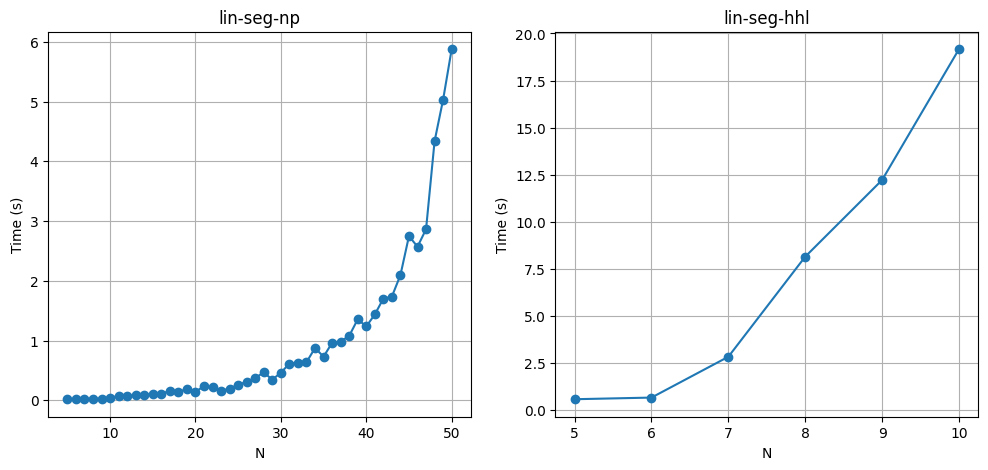

In [13]:
import matplotlib.pyplot as plt

fig, axes = plt.subplots(1, 2, figsize=(12,5))

axes[0].plot(xs, c_times, marker='o')
axes[0].set_xlabel('N')
axes[0].set_ylabel('Time (s)')
axes[0].set_title(C_MODE)
axes[0].grid(True)

xqs = xs[:(maxQN-minN+1)]
axes[1].plot(xqs, q_times, marker='o')
axes[1].set_xlabel('N')
axes[1].set_ylabel('Time (s)')
axes[1].set_title(Q_MODE)
axes[1].grid(True)
axes[1].xaxis.set_major_locator(plt.MultipleLocator(1, incr))

# fig.suptitle(cfdsim.format_sim(sim))

plt.savefig(f"comp-t-{sim.param['icbc']}.png")
plt.show()

In [14]:
from datafit import fit_log

for i in range(len(xqs)):
    if xqs[i] == 5:
        print(f"5x5: c={c_times[i]:4f}, q={q_times[i]:4f}")
    if xqs[i] == 10:
        print(f"10x10: c={c_times[i]:4f}, q={q_times[i]:4f}")

# Convertir de N a G
xsq = [xq**2 for xq in xqs]
yq = q_times
xsc = [x**2 for x in xs]
yc = c_times

print("FIT CLASSICAL")
fit_log(xsc, yc)

print("FIT QUANTUM")
fit_log(xsq, yq)

5x5: c=0.018144, q=0.571028
10x10: c=0.041073, q=19.162393
FIT CLASSICAL
Linear Fit:   y = 0.0016x + -0.5130
Quadratic Fit: y = 0.0000x² + -0.0010x + 0.2762
Cubic Fit:    y = 0.0000x³ + -0.0000x² + 0.0016x + -0.1337
Quartic Fit:  y = 0.0000x⁴ + -0.0000x³ + 0.0000x² + -0.0008x + 0.1016
Quintic Fit:  y = 0.0000x⁵ + -0.0000x⁴ + 0.0000x³ + -0.0000x² + 0.0008x + -0.0079
Exponential Fit (x scaled):
y = 0.0898 * e^(4.1499 * (x / max(x)))
Linear    : R² = 0.7773, MSE = 0.3954
Quadratic : R² = 0.9478, MSE = 0.0927
Cubic     : R² = 0.9823, MSE = 0.0315
Quartic   : R² = 0.9907, MSE = 0.0166
Quintic   : R² = 0.9920, MSE = 0.0142
Exponential: R² = 0.9860, MSE = 0.0248
FIT QUANTUM
Linear Fit:   y = 0.2579x + -7.9949
Quadratic Fit: y = 0.0021x² + -0.0014x + -1.3121
Cubic Fit:    y = -0.0000x³ + 0.0094x² + -0.4126x + 5.4543
Quartic Fit:  y = 0.0000x⁴ + -0.0006x³ + 0.0581x² + -2.1428x + 26.4065
Quintic Fit:  y = 0.0000x⁵ + -0.0000x⁴ + 0.0040x³ + -0.1935x² + 4.3097x + -35.4363
Exponential Fit (x scaled)